<a href="https://colab.research.google.com/github/TripopN/Walmart-stock-price-movement-prediction-with-logistic-regression/blob/main/LogisticRegression_6610422011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary lib

In [2]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4532    0  4532    0     0  15196      0 --:--:-- --:--:-- --:--:-- 15157
100  517k  100  517k    0     0   526k      0 --:--:-- --:--:-- --:--:--  526k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4520    0  4520    0     0  14794      0 --:--:-- --:--:-- --:--:-- 14771
100  392k  100  392k    0     0   507k      0 --:--:-- --:--:-- --:--:--  507k


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import talib as ta
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


## Get **Walmart** stock price from yahoo finance.

In [31]:
wmt = yf.Ticker('wmt')
interval = '1h'
start = '2022-03-1'
end = '2023-12-31'
df = wmt.history(interval=interval,start=start,end=end)

In [32]:
wmt_df =df.copy()

## Data Overview

In [15]:
wmt_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-03-01 09:30:00-05:00,135.869995,137.889999,135.649994,137.160004,1832286,0.0,0.0
2022-03-01 10:30:00-05:00,137.130005,137.720001,136.889999,137.510101,873266,0.0,0.0
2022-03-01 11:30:00-05:00,137.520004,137.520004,135.740005,135.850006,730723,0.0,0.0
2022-03-01 12:30:00-05:00,135.855103,136.360001,135.369995,135.389999,531727,0.0,0.0
2022-03-01 13:30:00-05:00,135.398499,135.789993,135.020004,135.619995,622989,0.0,0.0


In [17]:
wmt_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3222 entries, 2022-03-01 09:30:00-05:00 to 2023-12-29 15:30:00-05:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3222 non-null   float64
 1   High    3222 non-null   float64
 2   Low     3222 non-null   float64
 3   Close   3222 non-null   float64
 4   Volume  3222 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 151.0 KB


## Drop some columns and drop null.

In [33]:
wmt_df = wmt_df.drop(columns = ['Dividends','Stock Splits'])
wmt_df.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-03-01 09:30:00-05:00,135.869995,137.889999,135.649994,137.160004,1832286
2022-03-01 10:30:00-05:00,137.130005,137.720001,136.889999,137.510101,873266
2022-03-01 11:30:00-05:00,137.520004,137.520004,135.740005,135.850006,730723
2022-03-01 12:30:00-05:00,135.855103,136.360001,135.369995,135.389999,531727
2022-03-01 13:30:00-05:00,135.398499,135.789993,135.020004,135.619995,622989


In [34]:
wmt_df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

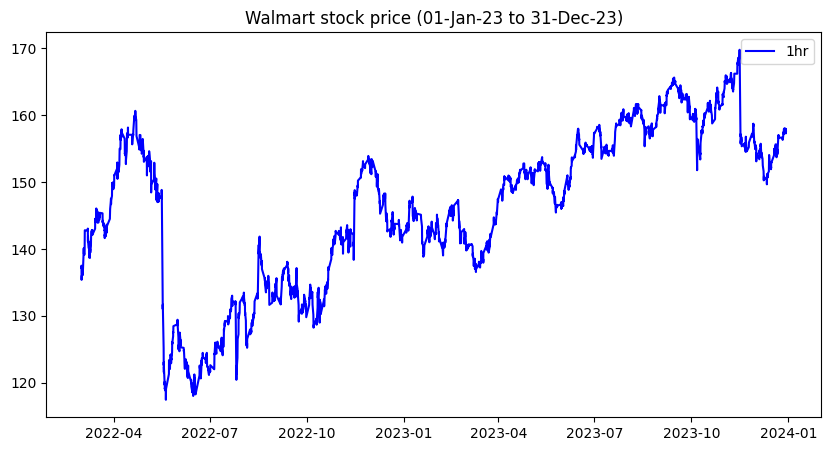

In [35]:
plt.figure(figsize = (10,5))
plt.plot(wmt_df['Close'], color ='b', label = '1hr')
plt.title("Walmart stock price (01-Jan-23 to 31-Dec-23)")
plt.legend()
plt.show()

#  1.Create model by follow method from https://blog.quantinsti.com/machine-learning-logistic-regression-python/

###  Define Predictor/Independent Variables

In [36]:
wmt_df['S_10'] = wmt_df['Close'].rolling(window=10).mean()
wmt_df['Corr'] = wmt_df['Close'].rolling(window=10).corr(wmt_df['S_10'])
wmt_df['RSI'] = ta.RSI(np.array(wmt_df['Close']), timeperiod =10)
wmt_df['Open-Close'] = wmt_df['Open'] - wmt_df['Close'].shift(1)
wmt_df['Open-Open'] = wmt_df['Open'] - wmt_df['Open'].shift(1)
wmt_df = wmt_df.dropna()

In [37]:
wmt_df.head(2)

,Open,High,Low,Close,Volume,S_10,Corr,RSI,Open-Close,Open-Open
Datetime,,,,,,,,,,
2022-03-03 13:30:00-05:00,140.000000,140.190002,139.740005,140.110001,750082,138.02999,0.904388,74.741951,0.000000,0.039993
2022-03-03 14:30:00-05:00,140.119995,140.119995,139.300003,139.850006,1129932,138.35799,0.866884,70.359714,0.009995,0.119995


### Determine X

In [38]:
X = wmt_df.iloc[:,:10]

### Define Target/Dependent Variable

In [39]:
y = np.where(wmt_df['Close'].shift(-1) > wmt_df['Close'],1,-1)

### Split The Dataset

In [40]:
split = int(0.7*len(wmt_df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [94]:
X_train.shape


(2242, 10)

### Instantiate The Logistic Regression in Python

In [41]:
model1 = LogisticRegression()
medel1 = model1.fit(X_train,y_train)

### Examine The Coefficients

In [42]:
pd.DataFrame(zip(X.columns, np.transpose(model1.coef_)))

,0,1
0,Open,[6.296860256525463e-12]
1,High,[6.334845440066811e-12]
2,Low,[6.240274473375973e-12]
3,Close,[6.310396810947348e-12]
4,Volume,[1.4908263494703996e-08]
5,S_10,[6.207995842076272e-12]
6,Corr,[1.4234921179940826e-14]
7,RSI,[3.121227709966219e-12]
8,Open-Close,[-4.5935849688522e-15]
9,Open-Open,[1.134583161680704e-14]


### Calculate Class Probabilities

In [43]:
# Specify the date for prediction
prediction_date = '2023-09-20'
probability = model1.predict_proba(X_test)
print(probability)

[[0.49881775 0.50118225]
 [0.49849361 0.50150639]
 [0.49791685 0.50208315]
 ...
 [0.49801255 0.50198745]
 [0.49700533 0.50299467]
 [0.49411219 0.50588781]]


### Predict Class Labels

In [44]:
predicted = model1.predict(X_test)

In [45]:
print(predicted)
print(len(predicted))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

### Date of prediction

In [46]:
test_dates = wmt_df.index[split:]

# Find the dates with predicted buy signals (Signal = 1)
buy_signal_dates = test_dates[predicted== 1]

# Print the date(s) with buy signal(s)
print("\nDate(s) with Buy Signal(s):")
print(buy_signal_dates)


Date(s) with Buy Signal(s):
DatetimeIndex(['2023-06-13 12:30:00-04:00', '2023-06-13 13:30:00-04:00',
               '2023-06-13 14:30:00-04:00', '2023-06-13 15:30:00-04:00',
               '2023-06-14 09:30:00-04:00', '2023-06-14 10:30:00-04:00',
               '2023-06-14 11:30:00-04:00', '2023-06-14 12:30:00-04:00',
               '2023-06-14 13:30:00-04:00', '2023-06-14 14:30:00-04:00',
               ...
               '2023-12-28 13:30:00-05:00', '2023-12-28 14:30:00-05:00',
               '2023-12-28 15:30:00-05:00', '2023-12-29 09:30:00-05:00',
               '2023-12-29 10:30:00-05:00', '2023-12-29 11:30:00-05:00',
               '2023-12-29 12:30:00-05:00', '2023-12-29 13:30:00-05:00',
               '2023-12-29 14:30:00-05:00', '2023-12-29 15:30:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Datetime', length=962, freq=None)


### Evaluate The Model

Confusion Metrix

In [47]:
print(metrics.confusion_matrix(y_test, predicted))

[[  0 452]
 [  0 510]]


Classification Metrix

In [48]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       452
           1       0.53      1.00      0.69       510

    accuracy                           0.53       962
   macro avg       0.27      0.50      0.35       962
weighted avg       0.28      0.53      0.37       962



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Create Trading Strategy Using The Model

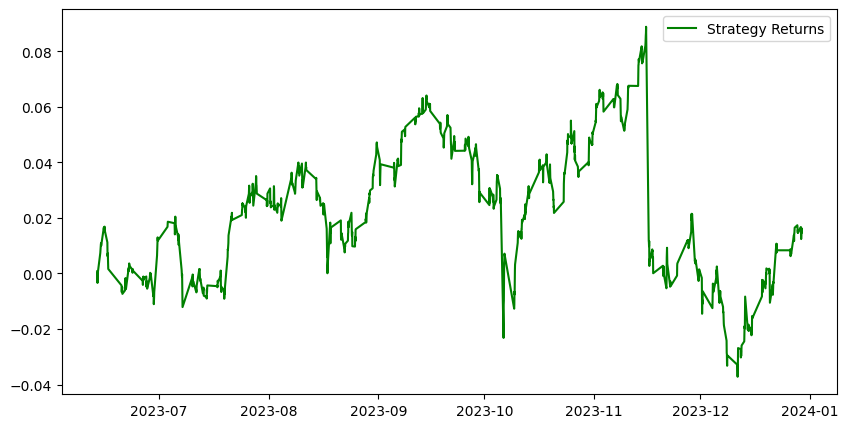

In [49]:
wmt_df['Predicted_Signal'] = model1.predict(X)
wmt_df['WMT_returns'] = np.log(wmt_df['Close']/wmt_df['Close'].shift(1))
Cumulative_WMT_returns = np.cumsum(wmt_df[split:]['WMT_returns'])


wmt_df['Strategy_returns'] = wmt_df['WMT_returns']* wmt_df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(wmt_df[split:]['Strategy_returns'])
plt.figure(figsize=(10,5))
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

# 2.Create another model by add some necessary feature.

In [274]:
wmt_df2 = df.copy()

In [275]:
wmt_df2 = wmt_df2.drop(columns =['Volume','Dividends','Stock Splits'])

### Define Predictor/Independent Variables

In [276]:
# Bollinger Bands
upper, middle, lower = ta.BBANDS(wmt_df2['Close'], timeperiod=5)
MACD_FAST = 20
MACD_SLOW = 50
MACD_SIGNAL = 9


In [277]:
wmt_df2['ema_50'] = wmt_df2['Close'].ewm(span=50, adjust=False, min_periods=5).mean()
wmt_df2['ema_20'] = wmt_df2['Close'].ewm(span=20, adjust=False, min_periods=5).mean()
wmt_df2['upperband'] = upper
wmt_df2['lowerband'] = lower
wmt_df2["ema_20-ema_50"] = wmt_df2['ema_20'] - wmt_df2['ema_50']
wmt_df2["macd"],wmt_df2["macdHist"],wmt_df2["macdSignal"] = ta.MACD(wmt_df2["Close"], fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)
wmt_df2 = wmt_df2.dropna()

# Bollinger Bands
# ind['MA_20'] = ind['Close'].rolling(window=20).mean()
# # ind['std_20'] = ind['Close'].rolling(window=20).std()
#ind['Upper_BB'] = ind['MA_20'] + 2 * ind['std_20']
# ind['Lower_BB'] = ind['MA_20'] - 2 * ind['std_20']

In [278]:
wmt_df2.head(3)

,Open,High,Low,Close,ema_50,ema_20,upperband,lowerband,ema_20-ema_50,macd,macdHist,macdSignal
Datetime,,,,,,,,,,,,
2022-03-11 10:30:00-05:00,142.755005,142.975006,142.360001,142.845001,140.254391,141.250823,142.969851,142.260147,0.996432,1.230227,1.026564,0.203664
2022-03-11 11:30:00-05:00,142.850006,142.889999,142.145004,142.472794,140.341387,141.367201,142.934278,142.340838,1.025814,1.245223,1.070296,0.174928
2022-03-11 12:30:00-05:00,142.479996,142.904999,142.430893,142.820007,140.438588,141.505564,142.981812,142.429308,1.066976,1.273060,1.110848,0.162211


### Define Target/Dependent Variable

In [279]:
y2 = np.where(wmt_df2['Close'].shift(-1) > wmt_df2['Close'],1,-1)

In [280]:
len(X2)

3165

In [281]:
X2 = wmt_df2.iloc[:,:12]

### Split The Dataset

In [282]:
split2 = int(0.7*len(wmt_df2))
X2_train, X2_test, y2_train, y2_test = X2[:split2], X2[split2:], y2[:split2], y2[split2:]

### Instantiate The Logistic Regression in Python

In [283]:
model2 = LogisticRegression()
model2 = model2.fit (X2_train,y2_train)

### Examine The Coefficients

In [284]:
pd.DataFrame(zip(X2.columns, np.transpose(model2.coef_)))

,0,1
0,Open,[-0.006998042537787406]
1,High,[0.02428014249572219]
2,Low,[-0.15660185398330442]
3,Close,[0.09783776042594557]
4,ema_50,[-0.021345371176805877]
5,ema_20,[-0.03849122818865509]
6,upperband,[0.021202421112529464]
7,lowerband,[0.08049721950206523]
8,ema_20-ema_50,[-0.017145857012028646]
9,macd,[-0.01572735889017519]


### Calculate Class Probabilities

In [285]:
# Specify the date for prediction
probability = model2.predict_proba(X2_test)
print(probability)

[[0.5120571  0.4879429 ]
 [0.50014968 0.49985032]
 [0.51028046 0.48971954]
 ...
 [0.5072842  0.4927158 ]
 [0.50431973 0.49568027]
 [0.51067168 0.48932832]]


### Predict Class Labels

In [286]:
predicted2 = model2.predict(X2_test)

In [287]:
print(predicted2)

[-1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1
 -1 -1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1 -1  1 -1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1 -1 -1  1  1  1  1
 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1  1  1
  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1 -1  1  1 -1 -1 -1  1  1  1  1  1 -1 -1  1 -1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

### Evaluate The Model

#### Confusion Matrix

In [288]:
print(metrics.confusion_matrix(y2_test, predicted2))

[[113 335]
 [123 379]]


#### Classification Report

In [289]:
print(metrics.classification_report(y2_test, predicted2))

              precision    recall  f1-score   support

          -1       0.48      0.25      0.33       448
           1       0.53      0.75      0.62       502

    accuracy                           0.52       950
   macro avg       0.50      0.50      0.48       950
weighted avg       0.51      0.52      0.49       950



## Create Trading Strategy Using The Model

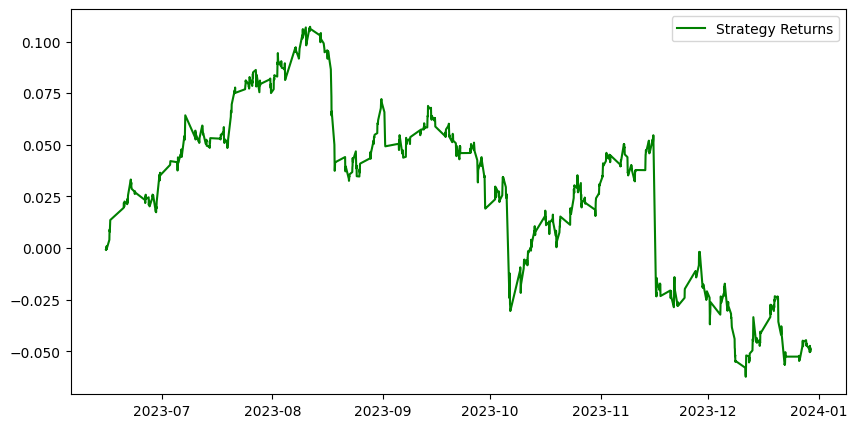

In [290]:
wmt_df2['Predicted_Signal'] = model2.predict(X2)
wmt_df2['wmt_returns'] = np.log(wmt_df2['Close']/wmt_df2['Close'].shift(1))
Cumulative_wmt_returns = np.cumsum(wmt_df2[split2:]['wmt_returns'])
wmt_df2['Strategy_returns'] = wmt_df2['wmt_returns']* wmt_df2['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(wmt_df2[split2:]['Strategy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

## Strategy comparison

In [291]:
wmt_df[split:]['Strategy_returns']

Datetime
2023-06-13 12:30:00-04:00    0.000772
2023-06-13 13:30:00-04:00   -0.001738
2023-06-13 14:30:00-04:00   -0.002452
2023-06-13 15:30:00-04:00    0.003160
2023-06-14 09:30:00-04:00    0.007633
                               ...   
2023-12-29 11:30:00-05:00   -0.003079
2023-12-29 12:30:00-05:00    0.001906
2023-12-29 13:30:00-05:00    0.000539
2023-12-29 14:30:00-05:00    0.001458
2023-12-29 15:30:00-05:00   -0.001521
Name: Strategy_returns, Length: 962, dtype: float64

In [292]:
split3 = int(0.7*len(df))
y3_train, y3_test = y[:split2], y[split2:]

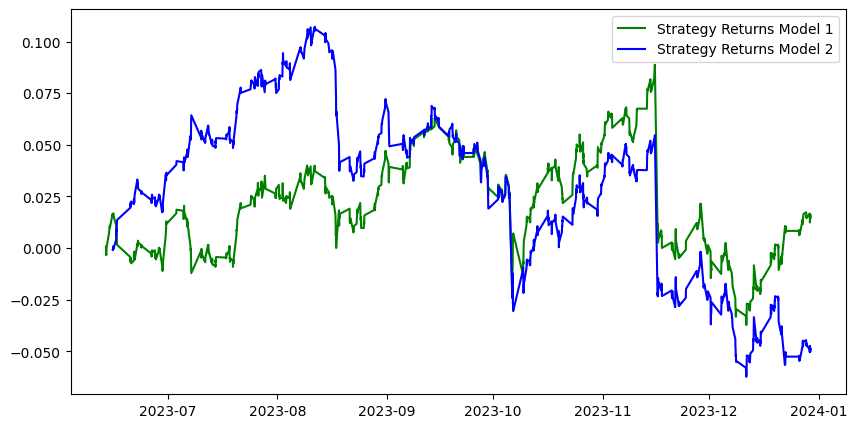

In [293]:
##1 RSI 2 MA
wmt_df['Predicted_Signal'] = model1.predict(X)
wmt_df['WMT_returns'] = np.log(wmt_df['Close']/wmt_df['Close'].shift(1))
Cumulative_WMT_returns = np.cumsum(wmt_df[split:]['WMT_returns'])
wmt_df['Strategy_returns'] = wmt_df['WMT_returns']* wmt_df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns_1 = np.cumsum(wmt_df[split:]['Strategy_returns'])

##2 2 EMA, MACD, Bollinger Bands
wmt_df2['Predicted_Signal'] = model2.predict(X2)
wmt_df2['wmt_returns'] = np.log(wmt_df2['Close']/wmt_df2['Close'].shift(1))
Cumulative_wmt_returns = np.cumsum(wmt_df2[split2:]['wmt_returns'])
wmt_df2['Strategy_returns'] = wmt_df2['wmt_returns']* wmt_df2['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns_2 = np.cumsum(wmt_df2[split2:]['Strategy_returns'])

#Plot
plt.figure(figsize=(10,5))
plt.plot(Cumulative_Strategy_returns_1 ,color='g', label = 'Strategy Returns Model 1')
plt.plot(Cumulative_Strategy_returns_2 ,color='b', label = 'Strategy Returns Model 2')
plt.legend()
plt.show()